# Transatlantic beer preferences

In the following, we will try to answer the following question: **do Americans prefer beers with high alcohol content compared to Europeans?**

## Preparations

### Importing modules

In [21]:
# Python modules
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import numpy as np
import statsmodels.api as sm
from tqdm import tqdm

# Custom module(s)
from load_data import load_gzip_txt_data

### Defining some helper functions

In [22]:
def get_continent(location: str) -> str:
    if not isinstance(location, str): # NOTE: This should never trigger, but we never know...
        return "Other"
    european_countries = [
        "Albania", "Andorra", "Armenia", "Austria", "Azerbaijan", "Belarus",
        "Belgium", "Bosnia and Herzegovina", "Bulgaria", "Croatia", "Cyprus",
        "Czech Republic", "Denmark", "England", "Estonia", "Finland", "France",
        "Georgia", "Germany", "Gibraltar", "Greece", "Hungary", "Iceland",
        "Ireland", "Italy", "Jersey", "Kazakhstan", "Kosovo", "Latvia",
        "Liechtenstein", "Lithuania", "Luxembourg", "Malta", "Moldova",
        "Monaco", "Montenegro", "Netherlands", "Northern Ireland", "Macedonia",
        "Norway", "Poland", "Portugal", "Romania", "Russia", "San Marino",
        "Scotland", "Serbia", "Slovakia", "Slovak Republic", "Slovenia",
        "Spain", "Sweden", "Switzerland", "Turkey", "Ukraine", "Vatican City",
        "Wales"
    ] # NOTE: This list has been defined in P2 milestone.
    if location in european_countries:
        return "Europe"
    elif location.startswith("United States") or location == 'Canada' or location == 'Mexico':
        return "America"
    else:
        return "Other"

def get_fit_equation(
        result: scipy.stats._stats_mstats_common.LinregressResult,
        decilams: int = 2
    ) -> str:
    """Returns the equation of the regression line."""
    # legend = f'$y = ({result.slope:.{decilams}f}\\pm{result.stderr:.{decilams}f})x + ({result.intercept:.{decilams}f}\\pm{result.intercept_stderr:.{decilams}f})$'
    legend = ""
    legend += "\n" + f"Slope: {result.slope:.{decilams}f} ± {result.stderr:.{decilams}f}"
    legend += "\n" + f"Intercept: {result.intercept:.{decilams}f} ± {result.intercept_stderr:.{decilams}f}"
    legend += "\n" + f"R-squared: {result.rvalue**2:.{decilams}f}"

    return legend.strip()

### Importing the data

Currently we only import beers from RateBeer. This will have to be modified to also import BeerAdvocate data.

In [23]:
BASE_PATH = './data/RateBeer/'
MAX_ENTRIES = int(1e6)
STANDARDIZE = False

# ---------
# IMPORTING
# ---------

# Importing ratings
ratings = load_gzip_txt_data(
    path=os.path.join(BASE_PATH, "ratings.txt.gz"),
    attributes=["beer_id", "rating", "user_id"],
    max_entries=MAX_ENTRIES,
)
ratings["rating"] = ratings["rating"].astype(float)
ratings.dropna(inplace=True)
ratings['user_id'] = ratings['user_id'].astype(str)
ratings['beer_id'] = ratings['beer_id'].astype(str)

# Importing user data
users = pd.read_csv(os.path.join(BASE_PATH, "users.csv"))
users['location'] = users['location'].astype(str)
users['user_id'] = users['user_id'].astype(str)

# Importing beers
beers = pd.read_csv(os.path.join(BASE_PATH, "beers.csv"))
beers['beer_id'] = beers['beer_id'].astype(str)
beers['brewery_id'] = beers['brewery_id'].astype(str)

# Importing breweries
breweries = pd.read_csv(os.path.join(BASE_PATH, "breweries.csv"))
breweries['id'] = breweries['id'].astype(str)

# ----------------
# ADDING CONTINENT
# ----------------

# Adding continent to users
users["continent"] = users["location"].apply(get_continent)
users = users.query("continent != 'Other'")

# Adding continent to breweries
breweries["continent"] = breweries["location"].apply(get_continent)
breweries = breweries.query("continent != 'Other'")

# -------
# MERGING
# -------

# Merging users with ratings
merged_ratings = pd.merge(
    left=ratings,
    right=users,
    on="user_id",
    how="left",
    suffixes=("_rating", "_user"),
)

# Merging beers and breweries
merged_beers = pd.merge(
    left=beers,
    right=breweries,
    left_on="brewery_id",
    right_on="id",
    how="left",
    suffixes=("_beer", "_brewery"),
)

# Merging ratings with beers
detailed_ratings = pd.merge(
    left=merged_ratings,
    right=merged_beers,
    left_on="beer_id",
    right_on="beer_id",
    how="left",
    suffixes=("_user", "_beer"),
)
detailed_ratings.dropna(subset=[
    'abv',
    'continent_beer',
    'continent_user',
], inplace=True) # NOTE: This is needed because some data are missing.

# Optional: standardizing ratings for each user
detailed_ratings_before_standardization = detailed_ratings.copy()
if STANDARDIZE:
    user_means = detailed_ratings.groupby("user_id")["rating"].transform("mean")
    user_stds = detailed_ratings.groupby("user_id")["rating"].transform("std")
    # Remove zeros, NaNs and infinities (for people having only a single review
    # or giving always the same rating)
    user_stds[user_stds == 0] = 1
    user_stds[np.isnan(user_stds)] = 1
    user_stds[np.isinf(user_stds)] = 1
    detailed_ratings["rating"] = (detailed_ratings["rating"] - user_means) / user_stds
    detailed_ratings["rating"].fillna(0, inplace=True)

# --------
# PRINTING
# --------

display(detailed_ratings)

Loading data from:  ./data/RateBeer/ratings.txt.gz


16999997it [00:15, 1096666.29it/s]


,beer_id,rating,user_id,nbr_ratings_user,user_name,joined,location_user,continent_user,beer_name,brewery_id,...,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings,id,location_beer,name,nbr_beers,continent_beer
38,155699,3.7,151109,982.0,ciaranc,1.326366e+09,Ireland,Europe,Ards Bally Black Stout,13538,...,4.6,3.866667,0.823699,6,3.866667,13538,Northern Ireland,Ards Brewing Co.,13.0,Europe
41,155699,4.0,224156,8.0,genegenie,1.350986e+09,Northern Ireland,Europe,Ards Bally Black Stout,13538,...,4.6,3.866667,0.823699,6,3.866667,13538,Northern Ireland,Ards Brewing Co.,13.0,Europe
43,155699,4.0,128086,4842.0,Beersiveknown,1.304590e+09,Northern Ireland,Europe,Ards Bally Black Stout,13538,...,4.6,3.866667,0.823699,6,3.866667,13538,Northern Ireland,Ards Brewing Co.,13.0,Europe
44,239097,3.0,128086,4842.0,Beersiveknown,1.304590e+09,Northern Ireland,Europe,Ards Belfast 366,13538,...,4.2,3.000000,NaN,0,NaN,13538,Northern Ireland,Ards Brewing Co.,13.0,Europe
45,380930,3.4,128086,4842.0,Beersiveknown,1.304590e+09,Northern Ireland,Europe,Ards Bittles Christmas,13538,...,4.2,3.400000,NaN,0,NaN,13538,Northern Ireland,Ards Brewing Co.,13.0,Europe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000399,39904,3.1,19400,23458.0,Papsoe,1.106910e+09,Denmark,Europe,Bruckmüller Helles,5271,...,4.9,2.782927,NaN,0,NaN,5271,Germany,Brauerei Bruckmüller,11.0,Europe
1000400,39904,2.9,5328,35316.0,Ungstrup,1.028714e+09,Denmark,Europe,Bruckmüller Helles,5271,...,4.9,2.782927,NaN,0,NaN,5271,Germany,Brauerei Bruckmüller,11.0,Europe
1000401,39904,2.9,1880,7409.0,motelpogo,1.002103e+09,Czech Republic,Europe,Bruckmüller Helles,5271,...,4.9,2.782927,NaN,0,NaN,5271,Germany,Brauerei Bruckmüller,11.0,Europe
1000402,39904,2.1,832,5207.0,duff,9.889704e+08,Denmark,Europe,Bruckmüller Helles,5271,...,4.9,2.782927,NaN,0,NaN,5271,Germany,Brauerei Bruckmüller,11.0,Europe


### Some sanity checks

In the following, we will just look at some bulk values to ensure the data is somewhat usable.

In [24]:
print(f"Mean rating of americains: " + str(detailed_ratings.query("continent_user == 'America'")["rating"].mean()))
print(f"Mean rating of europeans: " + str(detailed_ratings.query("continent_user == 'Europe'")["rating"].mean()))

Mean rating of americains: 3.193019154881099
Mean rating of europeans: 3.0500967638577143


In [25]:
# Before standardisation
most_rated_beers = detailed_ratings_before_standardization["beer_id"].value_counts().index[:1000]
rating_subset = detailed_ratings_before_standardization.query("beer_id in @most_rated_beers")
grouped_ratings = rating_subset.groupby("beer_id").agg('mean')
grouped_ratings.sort_values(by="rating", ascending=False, inplace=True)
indices_before = list(grouped_ratings.index)
indices_before_dict = {indices_before[i]: i for i in range(len(indices_before))}


# After standardisation
most_rated_beers = detailed_ratings["beer_id"].value_counts().index[:1000]
rating_subset = detailed_ratings.query("beer_id in @most_rated_beers")
grouped_ratings = rating_subset.groupby("beer_id").agg('mean')
grouped_ratings.sort_values(by="rating", ascending=False, inplace=True)
indices_after = list(grouped_ratings.index)
indices_after_dict = {indices_after[i]: i for i in range(len(indices_after))}



100%|██████████| 863976/863976 [00:00<00:00, 1920677.11it/s]


On average, the rank changed by 0.


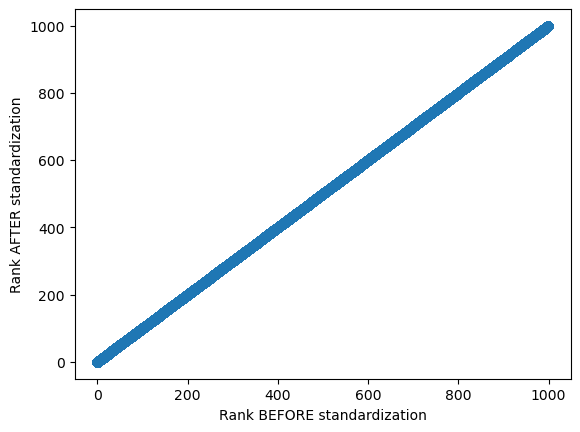

In [26]:
xs = []
ys = []

for index in tqdm(detailed_ratings["beer_id"].values):
    if index not in indices_after_dict or index not in indices_before_dict:
        continue
    rank_before = indices_after_dict[index]
    rank_after = indices_before_dict[index]
    xs.append(rank_before)
    ys.append(rank_after)
    
plt.scatter(xs, ys)
plt.xlabel("Rank BEFORE standardization")
plt.ylabel("Rank AFTER standardization")

# Is a beer good if it has a lot of good ratings, or because it is one people prefer on others?

print(f"On average, the rank changed by {abs(np.array(xs) - np.array(ys)).mean():.0f}.")

### The naive model in action

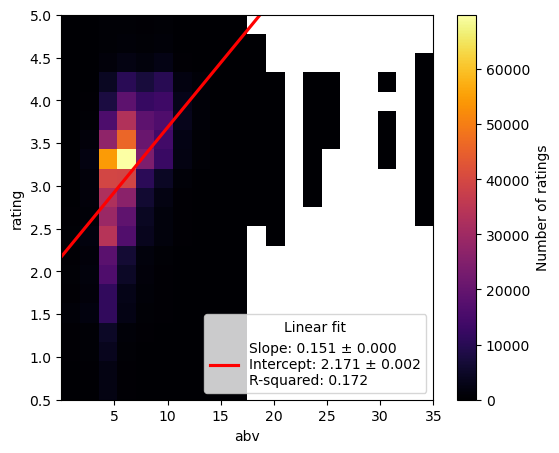

<Figure size 500x500 with 0 Axes>

In [27]:
# Initialize the figure
fig, ax = plt.subplots(figsize=(6, 5))

# Drawing the background histogram
plt.figure(figsize=(5, 5))
sns.histplot(
    data=detailed_ratings,
    x="abv",
    y="rating",
    bins=20, # NOTE: There are only ~50 unique values for ratings.
    cmap="inferno",
    ax=ax,
    cbar=True,
    cbar_kws={'label': 'Number of ratings'},
)

# Drawing the regression line (and eventually the scatter)
regplot = sns.regplot(
    data=detailed_ratings,
    x="abv",
    y="rating",
    scatter=False,
    x_jitter=0.1,
    y_jitter=0.1,
    marker='x',
    scatter_kws={'color':'k', 'alpha':0.01},
    line_kws={'color':'r', 'alpha':1.0},
    ax=ax,
)

# Computing the regression and some statistics
x = detailed_ratings['abv'].values
y = detailed_ratings['rating'].values
result = scipy.stats.linregress(x=x, y=y)

# Finalizing the plot
ax.legend([get_fit_equation(result, 3)], loc='lower right', title='Linear fit')
ax.set(xlim=(x.min(), x.max()), ylim=(y.min(), y.max()))
plt.show()

Looking at the figure above, it seems clear that the naive model performs pretty poorly (because of the high $R^2$). Thus, we won't probably be able to explain the ratings only by looking at the ABV.

Though, let's still compare the naive model when considering only Americans and Europeans. For this, let's start by check if the dataset is balanced.

In [28]:
print(f"Americans reviewing american beers: " + str(len(detailed_ratings.query("continent_user == 'America' and continent_beer == 'America'"))))
print(f"Americans reviewing european beers: " + str(len(detailed_ratings.query("continent_user == 'America' and continent_beer == 'Europe'"))))
print(f"Europeans reviewing american beers: " + str(len(detailed_ratings.query("continent_user == 'Europe' and continent_beer == 'America'"))))
print(f"Europeans reviewing european beers: " + str(len(detailed_ratings.query("continent_user == 'Europe' and continent_beer == 'Europe'"))))

Americans reviewing american beers: 306049
Americans reviewing european beers: 89777
Europeans reviewing american beers: 30616
Europeans reviewing european beers: 437534


For the purpose of what we are going to do, the dataset is balanced enough. But we could also perform a one-to-one matching.

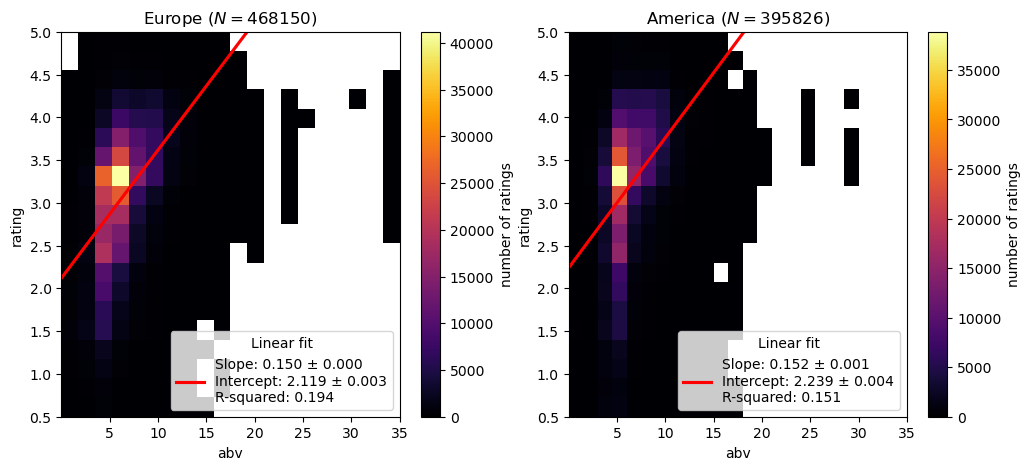

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [29]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))

fit_results = []

for continent_index, continent in enumerate(['Europe', 'America']):

    df_ = detailed_ratings.query(f'continent_user == @continent')

    # Drawing the background histogram
    plt.figure(figsize=(5, 5))
    sns.histplot(
        data=df_,
        x="abv",
        y="rating",
        bins=20, # NOTE: There are only ~50 unique values for ratings.
        cmap="inferno",
        ax=axes[continent_index],
        cbar=True,
        cbar_kws={'label': 'number of ratings'},
    )

    # Drawing the regression line
    regplot = sns.regplot(
        data=df_,
        x="abv",
        y="rating",
        scatter=False,
        x_jitter=0.1,
        y_jitter=0.1,
        marker='.',
        scatter_kws={'color':'k', 'alpha':0.1},
        line_kws={'color':'r', 'alpha':1.0},
        ax=axes[continent_index],
    )


    # Computing the regression and some statistics
    x = df_['abv'].values
    y = df_['rating'].values
    result = scipy.stats.linregress(x=x, y=y)
    fit_results.append(result)

    # Finalizing the plot
    axes[continent_index].legend([get_fit_equation(result, 3)], loc='lower right', title='Linear fit')
    axes[continent_index].set(
        xlim=(detailed_ratings['abv'].min(), detailed_ratings['abv'].max()),
        ylim=(detailed_ratings['rating'].min(), detailed_ratings['rating'].max()),
        title=f'{continent} ($N={len(df_)}$)',
    )

plt.show()

To see if the two datasets do follow the same trend, we can look more into details at the models' coefficients Below we have plotted the values of each of them as well as their standard error, supposing it is normally distributed.

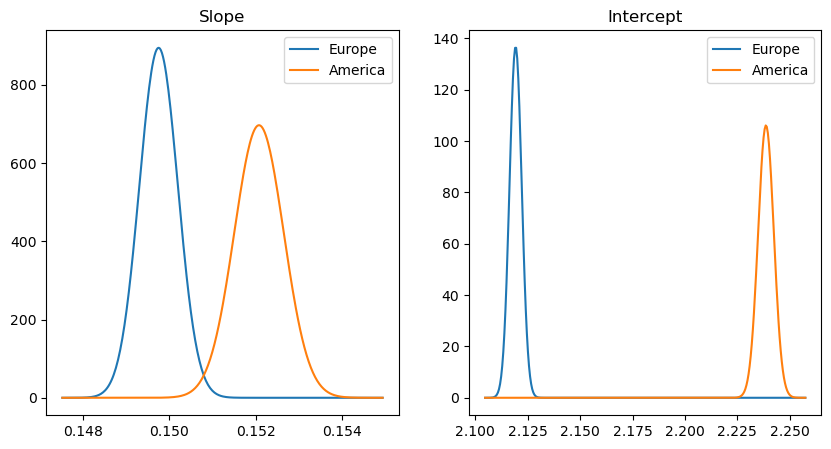

In [30]:
def gaussian(loc: float, scale: float, x: float) -> float:
    """Returns the value of a Gaussian distribution at a given point."""
    return scipy.stats.norm(loc=loc, scale=scale).pdf(x)

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

for continent_index, continent in enumerate(['Europe', 'America']):
    result = fit_results[continent_index]

    # Plot the slope informations
    x = np.linspace(
        start=min([result.slope - 5 * result.stderr for result in fit_results]),
        stop=max([result.slope + 5 * result.stderr for result in fit_results]),
        num=300,
    )
    y = gaussian(loc=result.slope, scale=result.stderr, x=x)
    axes[0].plot(x, y, label=continent)
    
    # Plot the intercept informations
    x = np.linspace(
        start=min([result.intercept - 5 * result.intercept_stderr for result in fit_results]),
        stop=max([result.intercept + 5 * result.intercept_stderr for result in fit_results]),
        num=300,
    )
    y = gaussian(loc=result.intercept, scale=result.intercept_stderr, x=x)
    axes[1].plot(x, y, label=continent)

axes[0].set_title('Slope')
axes[1].set_title('Intercept')
axes[0].legend()
axes[1].legend()


By visual inspection, it seems that altough the two distributions may have the same slope, we can argue that the intercepts are significantly different. 

**TODO: use some more rigorous statistical test to check if the two distributions are significantly different.**

Below we show the effect of the standard error on the slope and intercept of the models, by drawing a whole bunch of lines. In other words, the lines drawn below are other plausible fits that would fit the linear model.

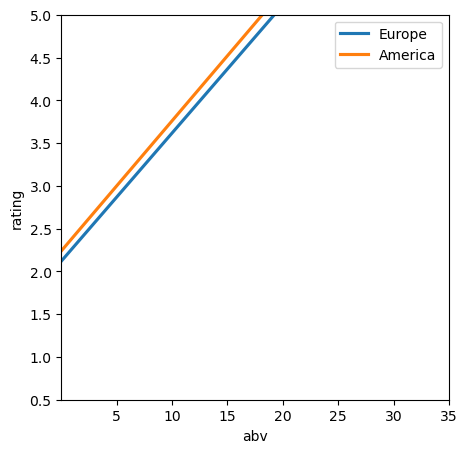

In [31]:
fig, ax = plt.subplots(figsize=(5, 5))

colors = ['tab:blue', 'tab:orange']

for continent_index, continent in enumerate(['Europe', 'America']):

    regplot = sns.regplot(
        data=detailed_ratings.query(f'continent_user == @continent'),
        x="abv",
        y="rating",
        scatter=False,
        x_jitter=0.1,
        y_jitter=0.1,
        marker='.',
        scatter_kws={'color':'k', 'alpha':0.1},
        line_kws={'color': colors[continent_index], 'alpha':1.0},
        ax=ax,
        label=continent,
    )
plt.xlim(detailed_ratings['abv'].min(), detailed_ratings['abv'].max())
plt.ylim(detailed_ratings['rating'].min(), detailed_ratings['rating'].max())
plt.legend()
plt.show()

### Performing one-to-one matching

We will now perform a one-to-one matching. We will match one european rating to an americain when they have rated the same beer. In the following, we perform an optimized one-to-one matching (since the number of unique beers is much smaller than the overall size of the dataset). **In fact, this is not true anymore as we look at a large portion of the dataset. To mitigate this, we will only look at the N most popular beers.**

In [32]:
# Taking only the most rated beers, half of them being european, half of them being american:
reviews_of_european_beers = detailed_ratings.query("continent_beer == 'Europe'")
reviews_of_american_beers = detailed_ratings.query("continent_beer == 'America'")
most_reviewed_european_beers = reviews_of_european_beers["beer_id"].value_counts().index[:1000]
most_reviewed_american_beers = reviews_of_american_beers["beer_id"].value_counts().index[:1000]
beer_ids = np.concatenate([most_reviewed_european_beers, most_reviewed_american_beers])

matched_rows = []

for beer_id in tqdm(beer_ids):
    american_reviews = detailed_ratings.query("beer_id == @beer_id and continent_user == 'America'")
    european_reviews = detailed_ratings.query("beer_id == @beer_id and continent_user == 'Europe'")
    min_review_count = min(len(american_reviews), len(european_reviews))
    if min_review_count == 0:
        continue
    american_indices = american_reviews.sample(min_review_count).index
    european_indices = european_reviews.sample(min_review_count).index
    matched_rows += list(american_indices) + list(european_indices)

matched_df = detailed_ratings.loc[matched_rows]

100%|██████████| 2000/2000 [03:37<00:00,  9.21it/s]


In the following, we show how well balanced the `matched_df` dataset is.

In [33]:
for continent_user in ['Europe', 'America']:
    for continent_beer in ['Europe', 'America']:
        print(
            f"{continent_user} users reviewing {continent_beer.lower()} beers: " \
            + str(len(matched_df.query("continent_user == @continent_user and continent_beer == @continent_beer")))
        )

Europe users reviewing europe beers: 46079
Europe users reviewing america beers: 22029
America users reviewing europe beers: 46079
America users reviewing america beers: 22029


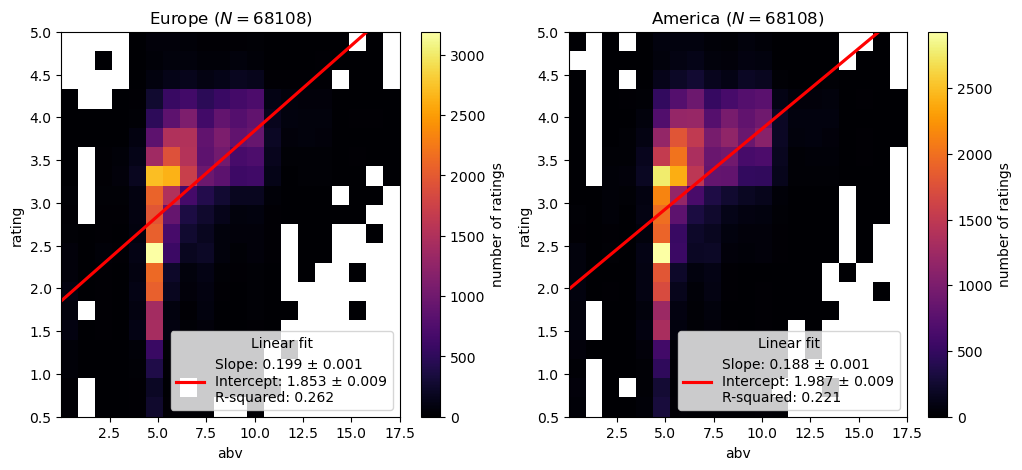

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [34]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))

fit_results = []

for continent_index, continent in enumerate(['Europe', 'America']):

    df_ = matched_df.query(f'continent_user == @continent')

    # Drawing the background histogram
    plt.figure(figsize=(5, 5))
    sns.histplot(
        data=df_,
        x="abv",
        y="rating",
        bins=20, # NOTE: There are only ~50 unique values for ratings.
        cmap="inferno",
        ax=axes[continent_index],
        cbar=True,
        cbar_kws={'label': 'number of ratings'},
    )

    # Drawing the regression line
    regplot = sns.regplot(
        data=df_,
        x="abv",
        y="rating",
        scatter=False,
        x_jitter=0.1,
        y_jitter=0.1,
        marker='.',
        scatter_kws={'color':'k', 'alpha':0.1},
        line_kws={'color':'r', 'alpha':1.0},
        ax=axes[continent_index],
    )

    # Computing the regression and some statistics
    x = df_['abv'].values
    y = df_['rating'].values
    result = scipy.stats.linregress(x=x, y=y)
    fit_results.append(result)

    # Finalizing the plot
    # legend_text = f'{get_fit_equation(result, 3)}\n ($R^2 = {result.rvalue**2:.2f}$)'
    axes[continent_index].legend([get_fit_equation(result, 3)], loc='lower right', title='Linear fit')
    axes[continent_index].set(
        xlim=(matched_df['abv'].min(), matched_df['abv'].max()),
        ylim=(matched_df['rating'].min(), matched_df['rating'].max()),
        title=f'{continent} ($N={len(df_)}$)',
    )
plt.show()

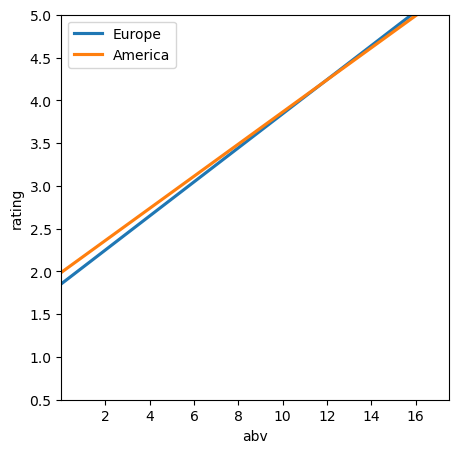

In [35]:
fig, ax = plt.subplots(figsize=(5, 5))

colors = ['tab:blue', 'tab:orange']

for continent_index, continent in enumerate(['Europe', 'America']):

    regplot = sns.regplot(
        data=matched_df.query(f'continent_user == @continent'),
        x="abv",
        y="rating",
        scatter=False,
        x_jitter=0.1,
        y_jitter=0.1,
        marker='.',
        scatter_kws={'color':'k', 'alpha':0.1},
        line_kws={'color': colors[continent_index], 'alpha':1.0},
        ax=ax,
        label=continent,
    )
plt.xlim(matched_df['abv'].min(), matched_df['abv'].max())
plt.ylim(matched_df['rating'].min(), matched_df['rating'].max())
plt.legend()
plt.show()